In [1]:
import os
import numpy as np
from PIL import Image
from numpy import sqrt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split

Important!!
Run instruction:
The code (Assignment V3.0.ipynb) must be placed at the same location with data subfolder inorder for the successful data reading.

In [2]:
def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []
    if root[len(root) - 1] == "B":
        image_size = (42, 48)
    else:
        image_size = (30, 37)

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            #img = img.resize([s//reduce for s in img.size])
            img = img.resize(image_size)

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load ORL dataset.
X_hat, Y_hat = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))

# Load Extended YaleB dataset.
X_hat, Y_hat = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))

ORL dataset: X_hat.shape = (1110, 400), Y_hat.shape = (400,)
Extended YalB dataset: X_hat.shape = (2016, 2414), Y_hat.shape = (2414,)


L1 normalized NMF

In [4]:
def l1_norm(v):
    return np.linalg.norm(v, ord=1)

def L1_NMF(E, U, V, max_iters):
    for i in range(max_iters):
        V = V * ((U.T @ E) / (U.T @ U @ V + 1e-7))
        U = U * ((E @ V.T) / (U @ V @ V.T + 1e-7))
        
        # Normalize U
        norm = np.apply_along_axis(l1_norm, 0, U)
        U = U / norm
        V = V * norm[:, np.newaxis]

        i += 1
    return U, V

L2 MUR NMF

In [5]:

def L2_MUR_NMF(image, k = 400, max_iters = 100):
    n, m = image.shape
    H = np.abs(np.random.rand(n, k))
    W = np.abs(np.random.rand(k, m))
    print("shape of image, H, W = ", image.shape, H.shape, W.shape)
    for _ in range(max_iters):
        H_numer = image.dot(W.T)
        H_denom = H.dot(W.dot(W.T))
        H_new = H * H_numer/ (H_denom + 1e-7)
        #H_new = np.multiply(H, (image.dot(W.T))/(H.dot(W.T).dot(W)) + 1e-7)
        W_numer = (H.T @ image)
        W_denom = (H.T @ H @ W)
        W_new = W * (W_numer / W_denom + 1e-7)
        H = H_new
        W = W_new
    return W, H

L21-norm NMF

In [6]:
class L21N_NMF():
    def __init__(self, n_components=100, max_iter=100, eps=1e-5, print_output=False):
        self.n_components = n_components
        self.max_iter = max_iter
        self.eps = eps
        self.print_output = print_output
        self.W = None
        self.H = None

    def fit(self, X):
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("Start")

        self.W = np.random.random((X.shape[0], self.n_components))
        self.H = np.random.random((self.n_components, X.shape[1]))

        for iter in range(self.max_iter):
            #epsilon = 1e-10  # 
            D = np.diag(1 / np.sqrt(np.sum(((X - self.W.dot(self.H)) ** 2), axis = 0)))
            W_new = self.W * ((X.dot(D).dot(self.H.T)) / (self.W.dot(self.H).dot(D).dot(self.H.T)))
            H_new = self.H * ((W_new.T.dot(X).dot(D)) / (W_new.T.dot(W_new).dot(self.H).dot(D)))
            
            
            # Frobenius norm is commonly used in NMF
            diff = np.linalg.norm(self.H - H_new) + np.linalg.norm(self.W - W_new)

            self.W = W_new
            self.H = H_new
            # Logging
            if diff <= self.eps:
                print("End")
                print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
                return self.W, self.H

            loss = np.sum(np.sqrt(np.sum((X - self.W.dot(self.H)) ** 2, axis = 0)))
            # Convergence check
            if self.print_output:
                if iter % 50 == 0:
                    print("Current iteration: %s(%s%%) /tloss: %.2f" % (iter, int((iter/self.max_iter)*100), loss))

        print("End")
        print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        return self.W, self.H

Function of cluster performance

In [7]:
def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

Noise functions


1: Gaussian noise


2: block occusion noise


3: salt & pepper noise

In [8]:
def create_gaussian_noise(image):
    mean = np.mean(image)
    image_noise = np.copy(image)
    noise = np.random.normal(mean, size = image.shape) * 0.5
    image_noise = (X + noise).clip(0)
    return image_noise

In [9]:
def create_block_occlusion_noise(image):
    block_size=(2, 2)
    image_noise = np.copy(image)
    x, y = np.random.randint(0, image.shape[0] - block_size[0]), np.random.randint(0, image.shape[1] - block_size[1])
    image_noise[x:x+block_size[0], y:y+block_size[1]] = 0
    return image_noise

In [10]:
def create_salt_pepper_noise(image):
    salt_prob=0.001
    pepper_prob=0.001
    image_noise = np.copy(image)
    total_pixels = image.shape[0] * image.shape[1]
    
    # Number of Salt pixels
    num_salt = np.ceil(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    image_noise[salt_coords] = 1

    # Number of Pepper pixels
    num_pepper = np.ceil(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    image_noise[pepper_coords] = 0
    return image_noise

Helper functions

In [11]:
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse


def assign_cluster_label(X, Y):
    assert X.shape[0] == Y.shape[0], f"Shape mismatch: {X.shape[0]} vs. {Y.shape[0]}"
    
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

L2 MUR experiment (basic test)

==> Load ORL dataset ...
X_hat.shape=(1110, 400), Y_hat.shape=(400,)


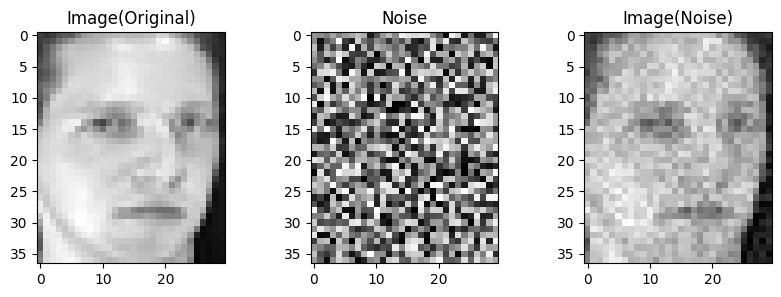

==> Apply NMF ...
shape of image, H, W =  (1110, 400) (1110, 400) (400, 400)
D.shape=(1110, 400), R.shape=(400, 400)
==> Evaluate RMSE ...
RMSE = 14.15513782517085


Text(0.5, 1.0, 'Image(Reconstructed)')

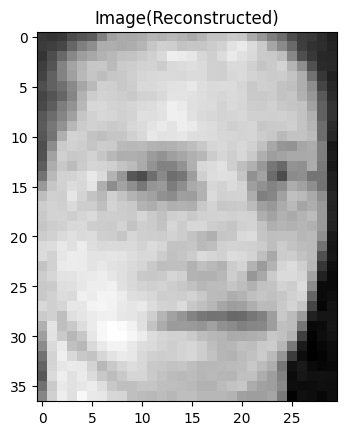

In [12]:
# Load dataset.
print('==> Load ORL dataset ...')
X_hat, Y_hat = load_data('data/ORL', reduce=3)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat.shape, Y_hat.shape))

# Add Noise.
X_noise = np.random.rand(*X_hat.shape) * 40
X = X_hat + X_noise

# Plot result.
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(X[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
n, m = X_hat.shape
k = 400
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
n, m = X_hat.shape
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
U, V = L2_MUR_NMF(X_hat, k, 1000)
# Obtain D and R separately.
D = V
R = U

# Print shapes
print('D.shape={}, R.shape={}'.format(D.shape, R.shape))

# Evaluate Root Means Square Errors .
print('==> Evaluate RMSE ...')
RMSE = sqrt(mean_squared_error(X_hat, D.dot(R)))
print('RMSE = {}'.format(RMSE))
plt.imshow(D.dot(R)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Reconstructed)')


Show noised images

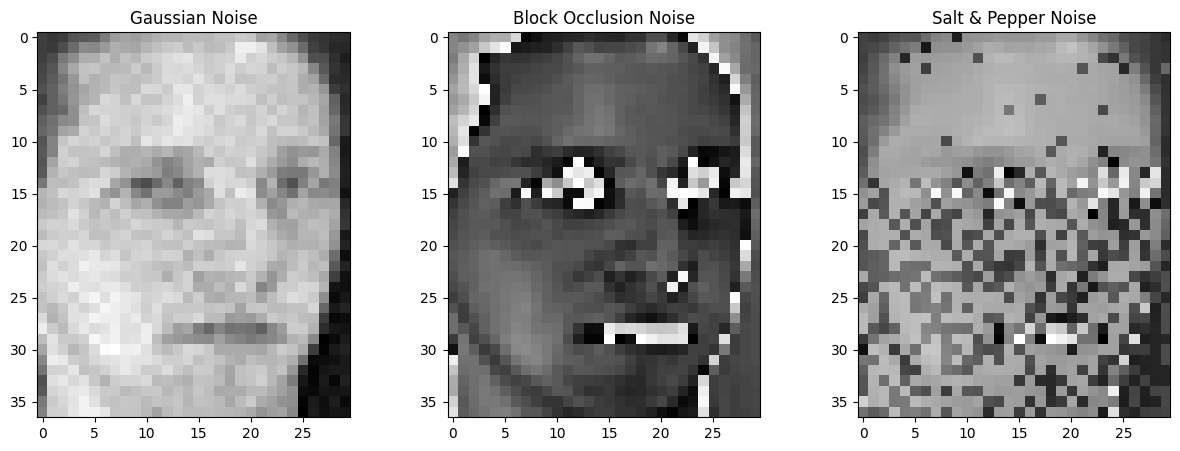

In [13]:
X_gaussian_noise = create_gaussian_noise(X_hat) + X_hat
X_BO_noise = create_block_occlusion_noise(X_hat) + X_hat
X_SP_noise = create_salt_pepper_noise(X_hat) + X_hat
# Create a figure
fig = plt.figure(figsize=(15, 5))

# Add a subplot for the image with Gaussian noise
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(X_gaussian_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax1.title.set_text('Gaussian Noise')

# Add a subplot for the image with block occlusion noise
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(X_BO_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax2.title.set_text('Block Occlusion Noise')

# Add a subplot for the image with salt & pepper noise
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(X_SP_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax3.title.set_text('Salt & Pepper Noise')

# Display the figure with all subplots
plt.show()

In [14]:
def add_salt_pepper_noise(X, salt_prob=0.01, pepper_prob=0.01):
    X_noised = X.copy()
    total_pixels = X.size
    
    # Add Salt noise
    num_salt = np.ceil(total_pixels * salt_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in X.shape]
    X_noised[tuple(coords)] = 1

    # Add Pepper noise
    num_pepper = np.ceil(total_pixels * pepper_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in X.shape]
    X_noised[tuple(coords)] = 0
    
    return X_noised

def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse

def show_reconstructed_img(X, X_noise, W, H, p=0.1):
    # Mapping of X.shape[0] to appropriate image dimensions
    img_size = {
        1110: (37, 30),
        # Add other mappings as needed
    }

    # Determine image size dynamically based on X.shape[0]
    image_size = img_size.get(X.shape[0], (48, 42))  # Default to (48, 42) if not found
    
    X_re = np.dot(W, H)

    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Original images and reconstructed images", size=20)

    # Showing original images
    for i in range(10):
        plt.subplot(3, 10, i+1)
        plt.imshow(X[:, i].reshape(image_size), cmap=plt.cm.gray)    
        plt.axis('off')  # Hide axis
    
    # Showing reconstructed images
    for i in range(10, 20):
        plt.subplot(3, 10, i+1)
        plt.imshow(X_re[:, i-10].reshape(image_size), cmap=plt.cm.gray)
        plt.axis('off')  # Hide axis
    
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Apply L2 MUR NMF for images with noise

Calculate the ACC(NMI) for different noise

In [15]:
print('==> Apply NMF ...')
k = 400
U, V = L2_MUR_NMF(X_gaussian_noise, k, 100)
D1 = U
R1 = V
print('==> Evaluate RMSE ...')
RMSE = sqrt(mean_squared_error(X_hat, R1.dot(D1)))
print('RMSE = {}'.format(RMSE))
progressed_1 = R1.dot(D1)
print('==> Evaluate Acc and NMI ...')
# Assign cluster labels.
Y_pred = assign_cluster_label(R1.T, Y_hat)
acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI)(Gaussian Noise) = {:.4f} ({:.4f})'.format(acc, nmi))

print('==> Apply NMF ...')
U, V = L2_MUR_NMF(X_BO_noise, k, 100)
D2 = U
R2 = V
print('==> Evaluate RMSE ...')
RMSE = sqrt(mean_squared_error(X_hat, R2.dot(D2)))
print('RMSE = {}'.format(RMSE))
progressed_2 = R2.dot(D2)
print('==> Evaluate Acc and NMI ...')
# Assign cluster labels.
Y_pred = assign_cluster_label(R2.T, Y_hat)
acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI)(block occulusion noise) = {:.4f} ({:.4f})'.format(acc, nmi))


print('==> Apply NMF ...')
U, V = L2_MUR_NMF(X_SP_noise, k, 100)
D3 = V
R3 = U
print('==> Evaluate RMSE ...')
RMSE = sqrt(mean_squared_error(X_hat, D3.dot(R3)))
print('RMSE = {}'.format(RMSE))
progressed_3 = D3.dot(R3)
print('==> Evaluate Acc and NMI ...')
# Assign cluster labels.
Y_pred = assign_cluster_label(R.T, Y_hat)
acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI)(salt & pepper noise) = {:.4f} ({:.4f})'.format(acc, nmi))

==> Apply NMF ...
shape of image, H, W =  (1110, 400) (1110, 400) (400, 400)
==> Evaluate RMSE ...
RMSE = 25.487579042169006
==> Evaluate Acc and NMI ...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI)(Gaussian Noise) = 0.1550 (0.2739)
==> Apply NMF ...
shape of image, H, W =  (1110, 400) (1110, 400) (400, 400)
==> Evaluate RMSE ...
RMSE = 67.83187637023282
==> Evaluate Acc and NMI ...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI)(block occulusion noise) = 0.1475 (0.2284)
==> Apply NMF ...
shape of image, H, W =  (1110, 400) (1110, 400) (400, 400)
==> Evaluate RMSE ...
RMSE = 42.216302665682534
==> Evaluate Acc and NMI ...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI)(salt & pepper noise) = 0.5825 (0.7503)


Create the reconstructed figures for different noise

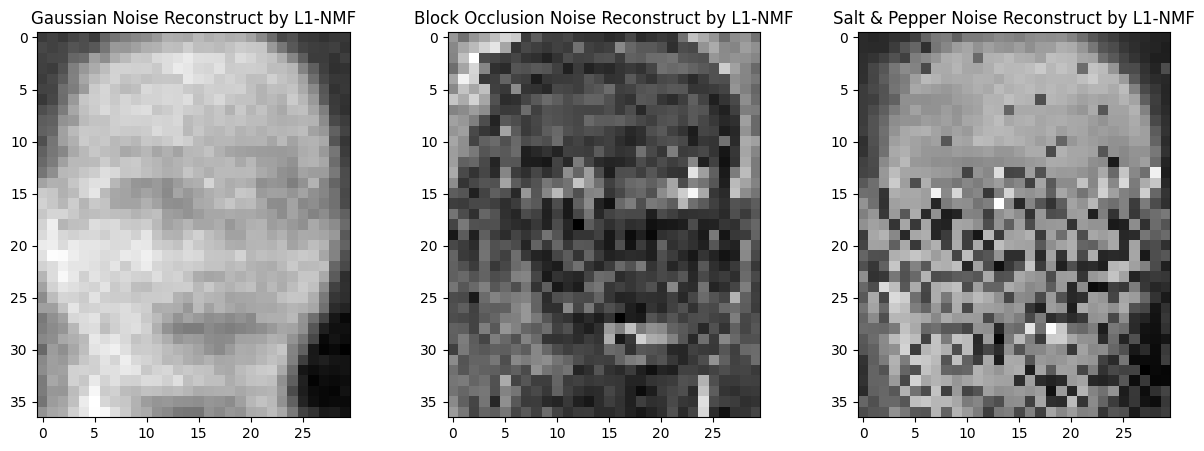

In [16]:
# Create a figure
fig = plt.figure(figsize=(15, 5))

# Add a subplot for the image with Gaussian noise
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(progressed_1[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax1.title.set_text('Gaussian Noise Reconstruct by L1-NMF')

# Add a subplot for the image with block occlusion noise
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(progressed_2[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax2.title.set_text('Block Occlusion Noise Reconstruct by L1-NMF')

# Add a subplot for the image with salt & pepper noise
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(progressed_3[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax3.title.set_text('Salt & Pepper Noise Reconstruct by L1-NMF')

# Display the figure with all subplots
plt.show()

==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (1110, 360) (1110, 360) (360, 360)
U.shape=(360, 360), V.shape=(1110, 360)
==> Evaluate RMSE...
RMSE = 48.1931
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1694 (0.2908)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (1110, 360) (1110, 360) (360, 360)
U.shape=(360, 360), V.shape=(1110, 360)
==> Evaluate RMSE...
RMSE = 47.5529
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1694 (0.2846)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (1110, 360) (1110, 360) (360, 360)
U.shape=(360, 360), V.shape=(1110, 360)
==> Evaluate RMSE...
RMSE = 48.3788
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1611 (0.3174)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (1110, 360) (1110, 360) (360, 360)
U.shape=(360, 360), V.shape=(1110, 360)
==> Evaluate RMSE...
RMSE = 48.6092
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1806 (0.3455)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (1110, 360) (1110, 360) (360, 360)
U.shape=(360, 360), V.shape=(1110, 360)
==> Evaluate RMSE...
RMSE = 48.5400
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1806 (0.3244)
###############




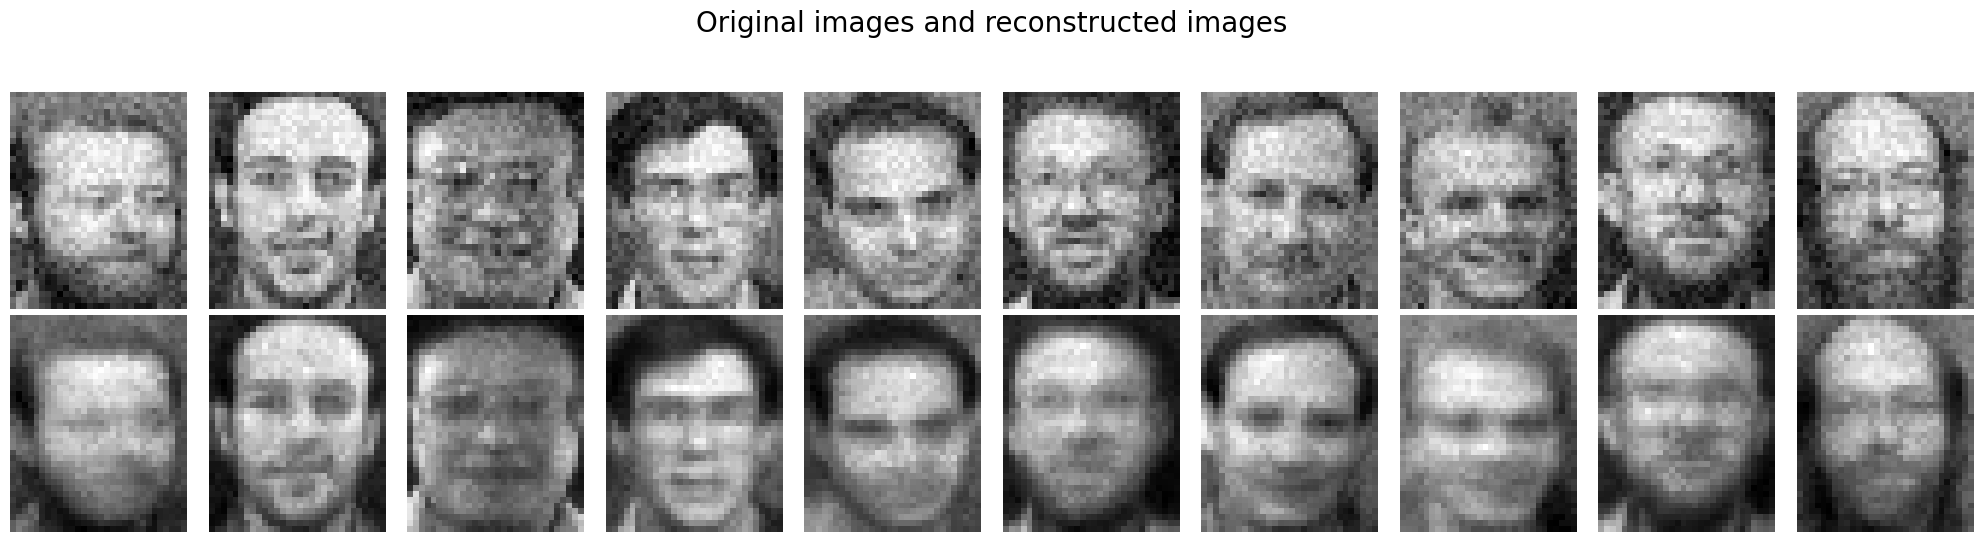

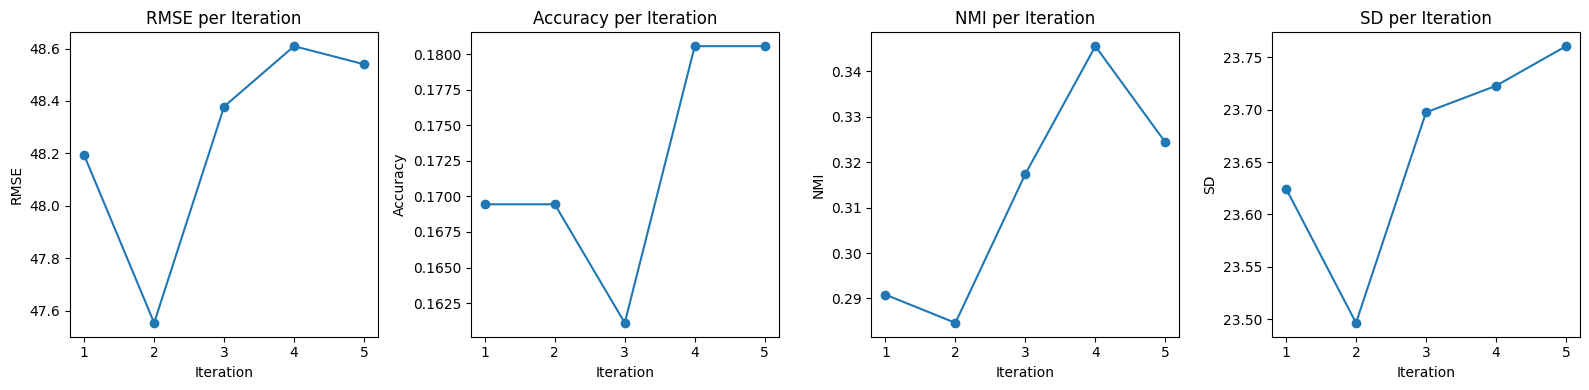

Mean RMSE: 48.2548
Mean Accuracy: 0.1722
Mean NMI: 0.3125


In [17]:
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse
# Set the number of iterations
num_iterations = 5
rmse_list = []
acc_list = []
nmi_list = []
sd_list = []
# Initialize lists to store RMSE and accuracy for each iteration
rmse_per_iteration = []
accuracy_per_iteration = []

for iteration in range(num_iterations):
    # Randomly split the data into train and test sets
    print('==> Load ORL dataset ...')
    X_hat, Y_hat = load_data('data/ORL', reduce=3)
    print(X_hat.shape)
    X_hat = np.nan_to_num(X_hat)
    V_hat, _, Y_hat, _ = train_test_split(X.T, Y_hat, test_size=0.1)
    V_hat = V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print('==> Add noise')
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    print('==> Apply L2 MUR NMF...')
    U, V = L2_MUR_NMF(V_hat, 360, 100)
    D = V
    R = U
    print('U.shape={}, V.shape={}'.format(U.shape, V.shape))
    print('==> Evaluate RMSE...')
    rmse = RMSE(V_hat, D, R)
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))
    print('==> Evaluate Acc and NMI...')
    V = np.nan_to_num(V)
    Y_pred = assign_cluster_label(V.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    accuracy_per_iteration.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    reconstruction_error = V_hat - D.dot(R)
    std_deviation = np.std(reconstruction_error)
    sd_list.append(std_deviation)
    print("###############\n\n")
show_reconstructed_img(V_hat, V_noise, D, R, 0.1)
# Plot RMSE, Accuracy, NMI, and SD for each iteration
plt.figure(figsize=(16, 4))

# RMSE subplot
plt.subplot(141)
plt.plot(range(1, num_iterations + 1), rmse_list, marker='o')
plt.title('RMSE per Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

# Accuracy subplot
plt.subplot(142)
plt.plot(range(1, num_iterations + 1), acc_list, marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# NMI subplot
plt.subplot(143)
plt.plot(range(1, num_iterations + 1), nmi_list, marker='o')
plt.title('NMI per Iteration')
plt.xlabel('Iteration')
plt.ylabel('NMI')

# SD subplot
plt.subplot(144)
plt.plot(range(1, num_iterations + 1), sd_list, marker='o')
plt.title('SD per Iteration')
plt.xlabel('Iteration')
plt.ylabel('SD')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")

==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (2016, 2172) (2016, 2172) (2172, 2172)
U.shape=(2172, 2172), V.shape=(2016, 2172)
==> Evaluate RMSE...
RMSE = 623.8543
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.0681 (0.0587)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (2016, 2172) (2016, 2172) (2172, 2172)
U.shape=(2172, 2172), V.shape=(2016, 2172)
==> Evaluate RMSE...
RMSE = 626.3085
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.0663 (0.0576)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (2016, 2172) (2016, 2172) (2172, 2172)
U.shape=(2172, 2172), V.shape=(2016, 2172)
==> Evaluate RMSE...
RMSE = 624.7498
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.0668 (0.0609)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (2016, 2172) (2016, 2172) (2172, 2172)
U.shape=(2172, 2172), V.shape=(2016, 2172)
==> Evaluate RMSE...
RMSE = 625.3569
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.0635 (0.0569)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
shape of image, H, W =  (2016, 2172) (2016, 2172) (2172, 2172)
U.shape=(2172, 2172), V.shape=(2016, 2172)
==> Evaluate RMSE...
RMSE = 625.1014
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.0622 (0.0534)
###############




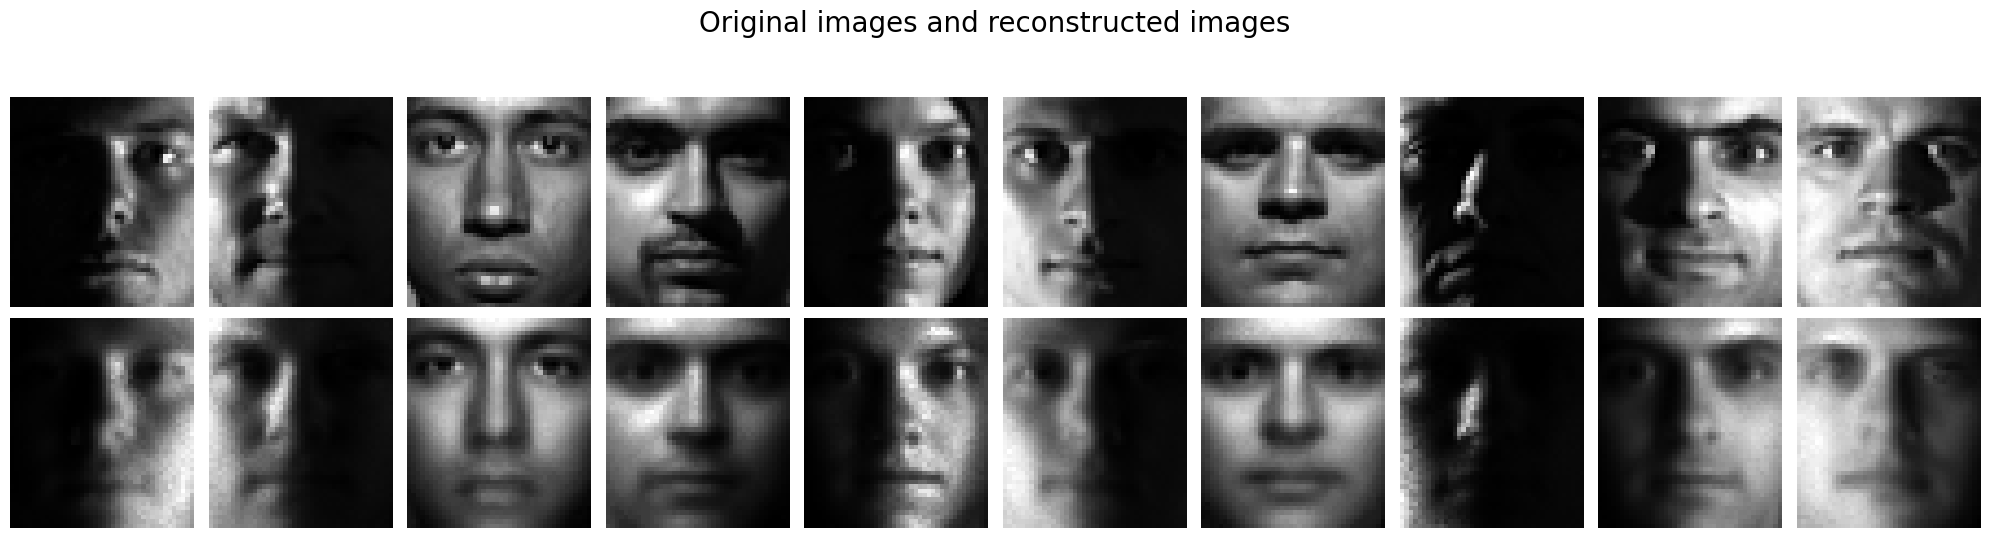

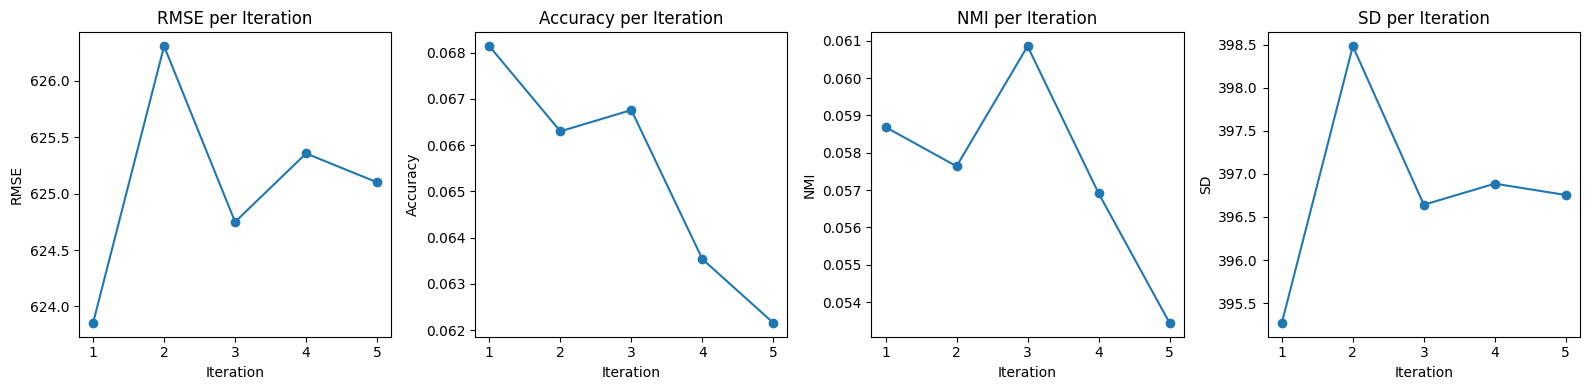

Mean RMSE: 625.0742
Mean Accuracy: 0.0654
Mean NMI: 0.0575


In [18]:
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse
# Set the number of iterations
num_iterations = 5
rmse_list = []
acc_list = []
nmi_list = []
sd_list = []
# Initialize lists to store RMSE and accuracy for each iteration
rmse_per_iteration = []
accuracy_per_iteration = []

for iteration in range(num_iterations):
    # Randomly split the data into train and test sets
    print('==> Load YaleB dataset ...')
    X_hat, Y_hat = load_data('data/CroppedYaleB', reduce=3)
    X_hat = np.nan_to_num(X_hat)
    V_hat, _, Y_hat, _ = train_test_split(X_hat.T, Y_hat, test_size=0.1)
    V_hat = V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print('==> Add noise')
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    print('==> Apply L2 MUR NMF...')
    U, V = L2_MUR_NMF(V_hat, k=V_hat.shape[1], max_iters= 50)
    D = V
    R = U
    print('U.shape={}, V.shape={}'.format(U.shape, V.shape))
    print('==> Evaluate RMSE...')
    #print(V_hat.shape, D.shape, R.shape)
    rmse = RMSE(V_hat, D, R)
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))
    print('==> Evaluate Acc and NMI...')
    V = np.nan_to_num(V)
    Y_pred = assign_cluster_label(V.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    accuracy_per_iteration.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    reconstruction_error = V_hat - D.dot(R)
    std_deviation = np.std(reconstruction_error)
    sd_list.append(std_deviation)
    print("###############\n\n")
show_reconstructed_img(V_hat, V_noise, V, U, 0.1)
# Plot RMSE, Accuracy, NMI, and SD for each iteration
plt.figure(figsize=(16, 4))

# RMSE subplot
plt.subplot(141)
plt.plot(range(1, num_iterations + 1), rmse_list, marker='o')
plt.title('RMSE per Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

# Accuracy subplot
plt.subplot(142)
plt.plot(range(1, num_iterations + 1), acc_list, marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# NMI subplot
plt.subplot(143)
plt.plot(range(1, num_iterations + 1), nmi_list, marker='o')
plt.title('NMI per Iteration')
plt.xlabel('Iteration')
plt.ylabel('NMI')

# SD subplot
plt.subplot(144)
plt.plot(range(1, num_iterations + 1), sd_list, marker='o')
plt.title('SD per Iteration')
plt.xlabel('Iteration')
plt.ylabel('SD')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")

L21 NMF Part

L21 add salt & pepper function

In [19]:
def add_salt_pepper_noise(X, salt_prob=0.01, pepper_prob=0.01):
    X_noised = X.copy()
    total_pixels = X.size
    
    # Add Salt noise
    num_salt = np.ceil(total_pixels * salt_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in X.shape]
    X_noised[tuple(coords)] = 1

    # Add Pepper noise
    num_pepper = np.ceil(total_pixels * pepper_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in X.shape]
    X_noised[tuple(coords)] = 0
    
    return X_noised

Show noise image

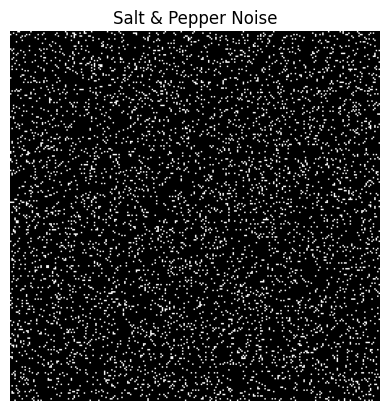

In [20]:
def generate_salt_pepper_noise(image_shape, salt_prob=0.01, pepper_prob=0.01):
    # Initialize a blank image
    noise_image = np.zeros(image_shape, dtype=np.uint8)
    total_pixels = np.prod(image_shape)
    
    # Generate Salt noise
    num_salt = np.ceil(total_pixels * salt_prob).astype(int)
    coords = [np.random.randint(0, i, num_salt) for i in image_shape]
    noise_image[tuple(coords)] = 1
    
    # Generate Pepper noise
    num_pepper = np.ceil(total_pixels * pepper_prob).astype(int)
    coords = [np.random.randint(0, i, num_pepper) for i in image_shape]
    noise_image[tuple(coords)] = 0
    
    return noise_image

def plot_image(img, title):
    plt.imshow(img, cmap='gray', vmin=0, vmax=1) 
    plt.title(title)
    plt.axis('off')
    plt.show()

noise_img = generate_salt_pepper_noise((256, 256), salt_prob=0.1, pepper_prob=0.1)

plot_image(noise_img, 'Salt & Pepper Noise')

show image functions

In [21]:
def reconstructed_img(X, X_noise, W, H, p=0.1):
    # Mapping of X.shape[0] to appropriate image dimensions
    img_size = {
        1110: (37, 30),
        # Add other mappings as needed
    }

    # Determine image size dynamically based on X.shape[0]
    image_size = img_size.get(X.shape[0], (48, 42))  # Default to (48, 42) if not found
    
    X_re = np.dot(W, H)

    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Original images, noised images and reconstructed images", size=20)

    # Showing original images
    for i in range(10):
        plt.subplot(3, 10, i+1)
        plt.imshow(X[:, i].reshape(image_size), cmap=plt.cm.gray)    
        plt.axis('off')  # Hide axis
    
    
    for i in range(10, 20):
        plt.subplot(3, 10, i+1)
        plt.imshow(X_noise[:, i-10].reshape(image_size), cmap=plt.cm.gray)
        plt.axis('off')  # Hide axis

    for i in range(20, 30):
        plt.subplot(3, 10, i+1)
        plt.imshow(X_re[:, i-20].reshape(image_size), cmap=plt.cm.gray)
        plt.axis('off')
    
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

==> Load ORL dataset...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 655703.29
Current iteration: 50(50%) /tloss: 582323.72
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W.shape=(1110, 40), H.shape=(40, 360)
==> Evaluate RMSE...
RMSE = 33.3033
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.5500 (0.7082)
###############


==> Load ORL dataset...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 657487.13
Current iteration: 50(50%) /tloss: 583634.27
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W.shape=(1110, 40), H.shape=(40, 360)
==> Evaluate RMSE...
RMSE = 33.5100
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.5167 (0.7007)
###############


==> Load ORL dataset...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 656558.88
Current iteration: 50(50%) /tloss: 582295.47
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W.shape=(1110, 40), H.shape=(40, 360)
==> Evaluate RMSE...
RMSE = 33.2795
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.5278 (0.6851)
###############


==> Load ORL dataset...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 656144.33
Current iteration: 50(50%) /tloss: 581865.66
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W.shape=(1110, 40), H.shape=(40, 360)
==> Evaluate RMSE...
RMSE = 33.3797
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.4917 (0.6832)
###############


==> Load ORL dataset...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 658101.70
Current iteration: 50(50%) /tloss: 585591.63
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W.shape=(1110, 40), H.shape=(40, 360)
==> Evaluate RMSE...
RMSE = 33.3748
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.5111 (0.6976)
###############


Mean RMSE: 33.3695
Mean Accuracy: 0.5194
Mean NMI: 0.6950


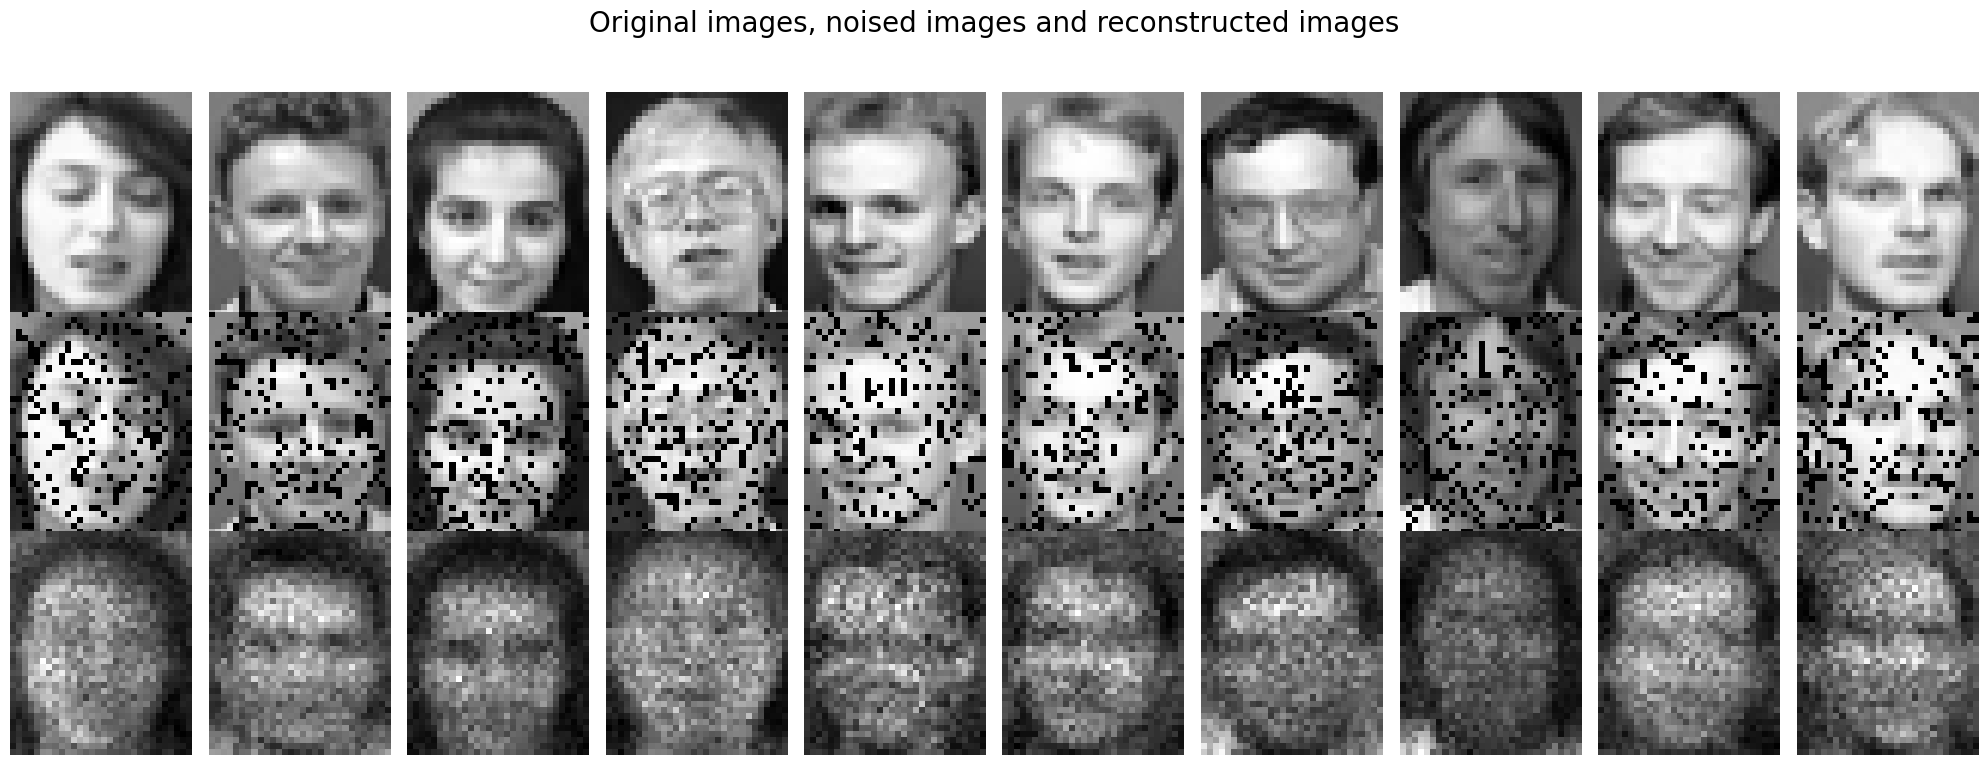

In [22]:
rmse_list = []
acc_list = []
nmi_list = []
p = 0.1
for i in range(5):
    print('==> Load ORL dataset...')
    X, Y = load_data(root='data/ORL', reduce=2)
    X = np.nan_to_num(X)
    V_hat, _, Y_hat, _ = train_test_split(X.T, Y, test_size = 0.1)
    V_hat = V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

    print('==> Add noise')
    #V_noise = add_block_noise(V_hat, p = 0.1)
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    print('==> Apply L21 NMF...')
    model = L21N_NMF(n_components = len(set(Y_hat)), max_iter = 100, eps = 1e-3, print_output=True)
    W, H = model.fit(V_noise)
    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

    print('==> Evaluate RMSE...')
    rmse = RMSE(V_hat, W, H)
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))

    print('==> Evaluate Acc and NMI...')
    H = np.nan_to_num(H)
    Y_pred = assign_cluster_label(H.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)

    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    print("###############\n\n")
reconstructed_img(V_hat, V_noise, W, H, p)
mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")

YaleB


==> Load YaleB dataset...
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 5106902.86
Current iteration: 50(50%) /tloss: 3737865.08
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
==> Evaluate RMSE...
RMSE = 26.4491
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1800 (0.2448)
###############


==> Load YaleB dataset...
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 5123141.04
Current iteration: 50(50%) /tloss: 3738334.96
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
==> Evaluate RMSE...
RMSE = 26.3040
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1809 (0.2467)
###############


==> Load YaleB dataset...
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 5108485.26
Current iteration: 50(50%) /tloss: 3728529.61
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
==> Evaluate RMSE...
RMSE = 26.4928
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1938 (0.2490)
###############


==> Load YaleB dataset...
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 5102741.98
Current iteration: 50(50%) /tloss: 3728728.85
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
==> Evaluate RMSE...
RMSE = 26.4868
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1915 (0.2518)
###############


==> Load YaleB dataset...
==> Add noise
==> Apply L21 NMF...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Start
Current iteration: 0(0%) /tloss: 5119485.26
Current iteration: 50(50%) /tloss: 3744905.86
End
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
==> Evaluate RMSE...
RMSE = 26.5195
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.1911 (0.2452)
###############


Mean RMSE: 26.4504
Mean Accuracy: 0.1875
Mean NMI: 0.2475


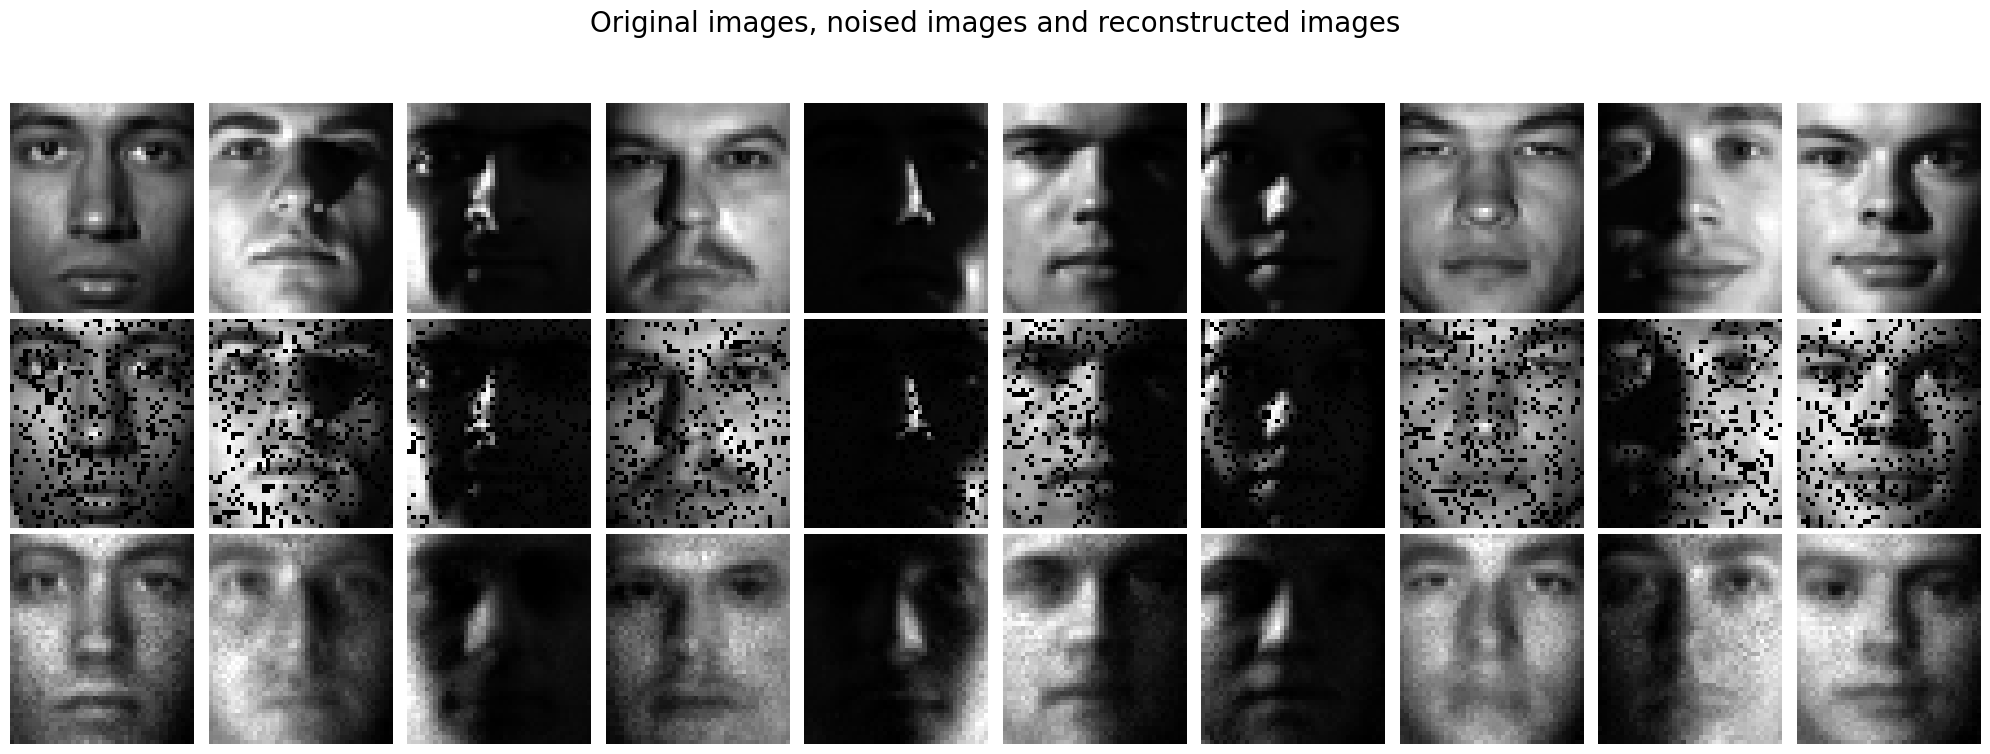

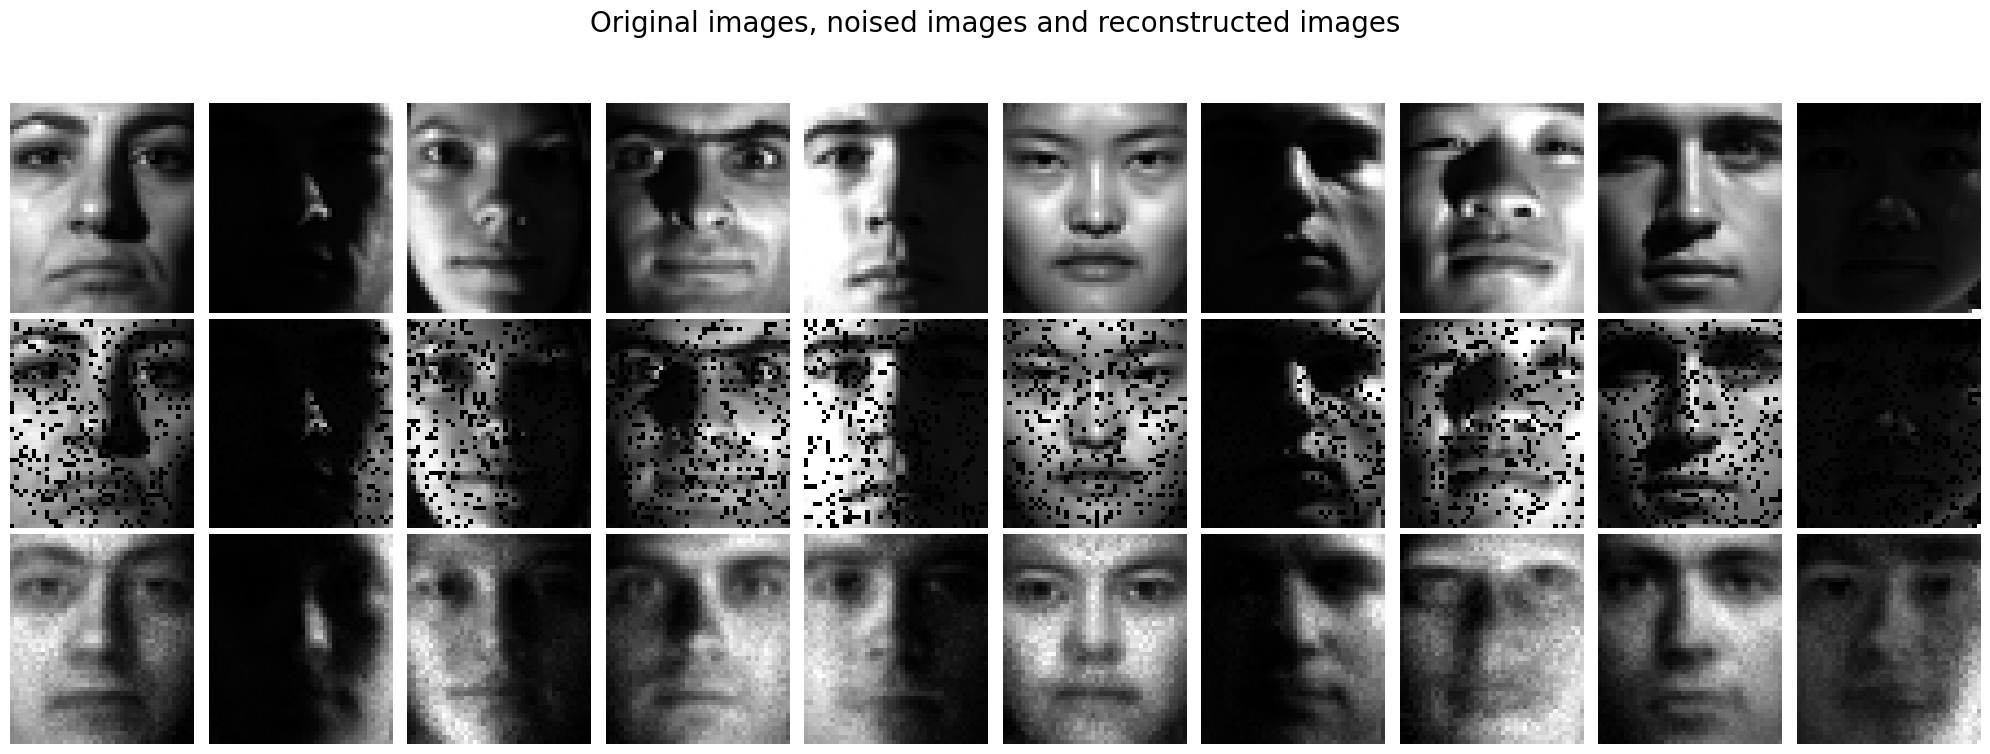

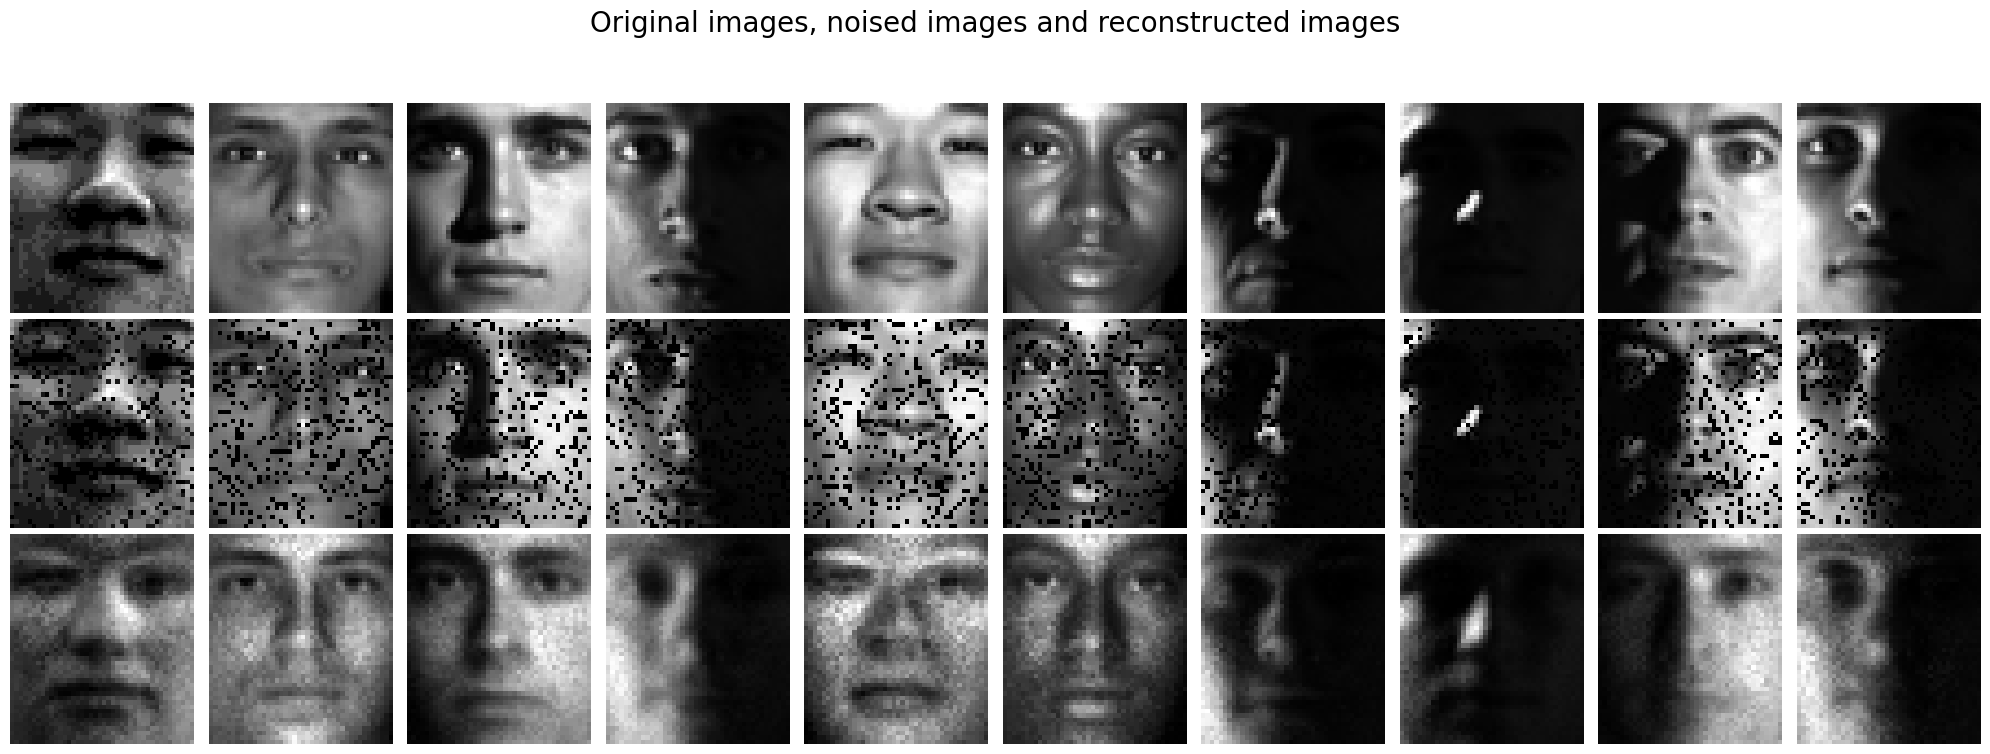

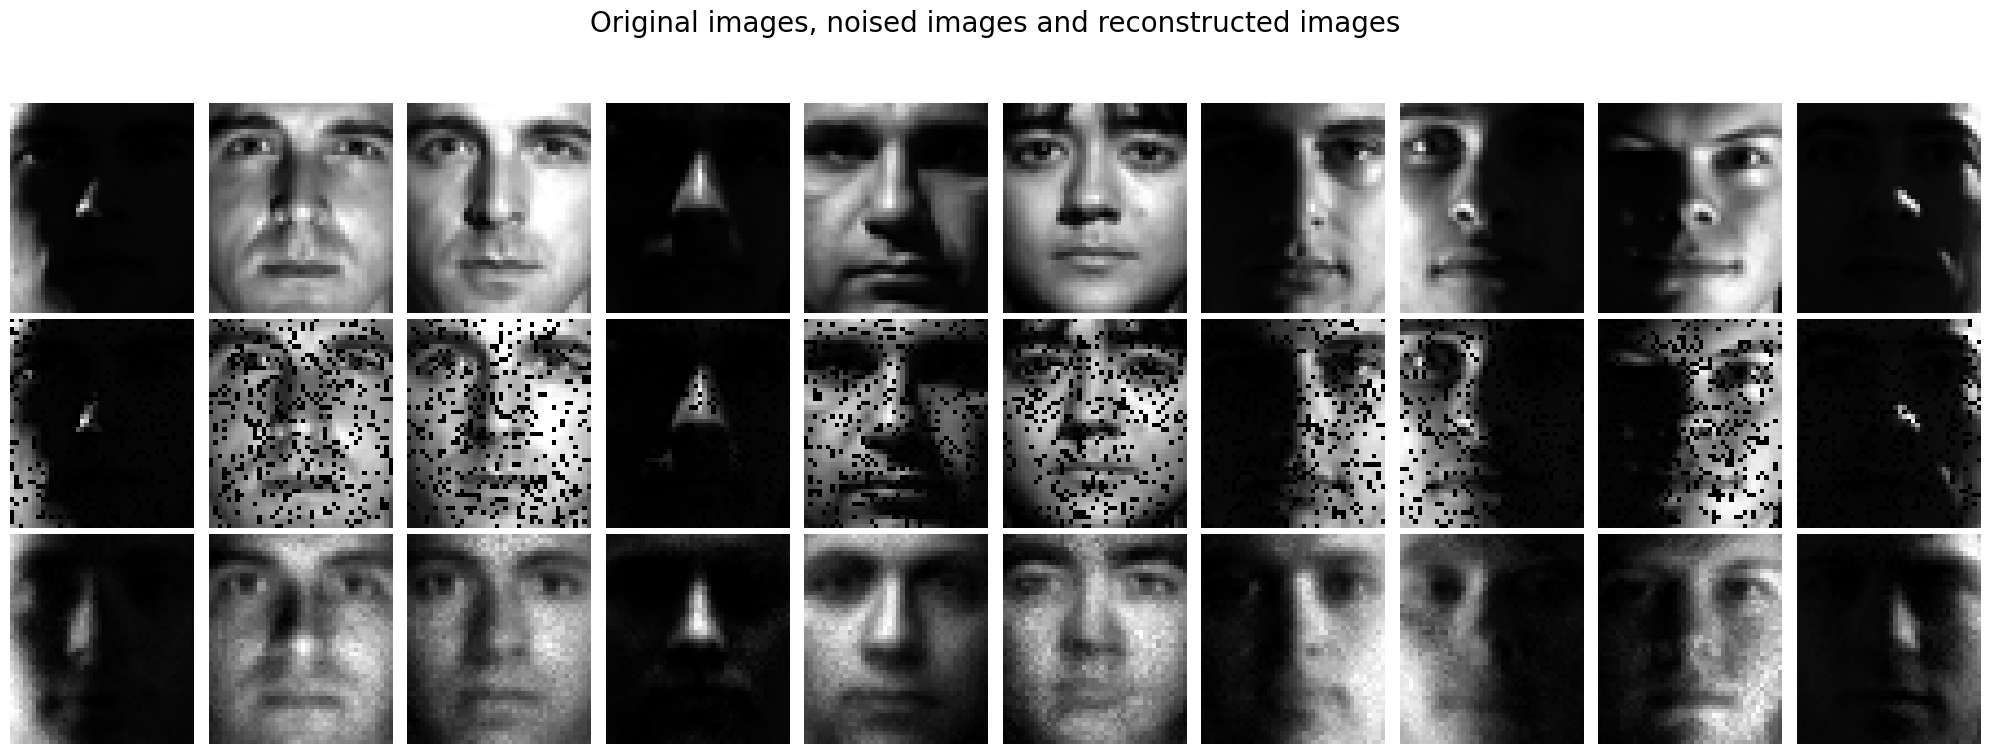

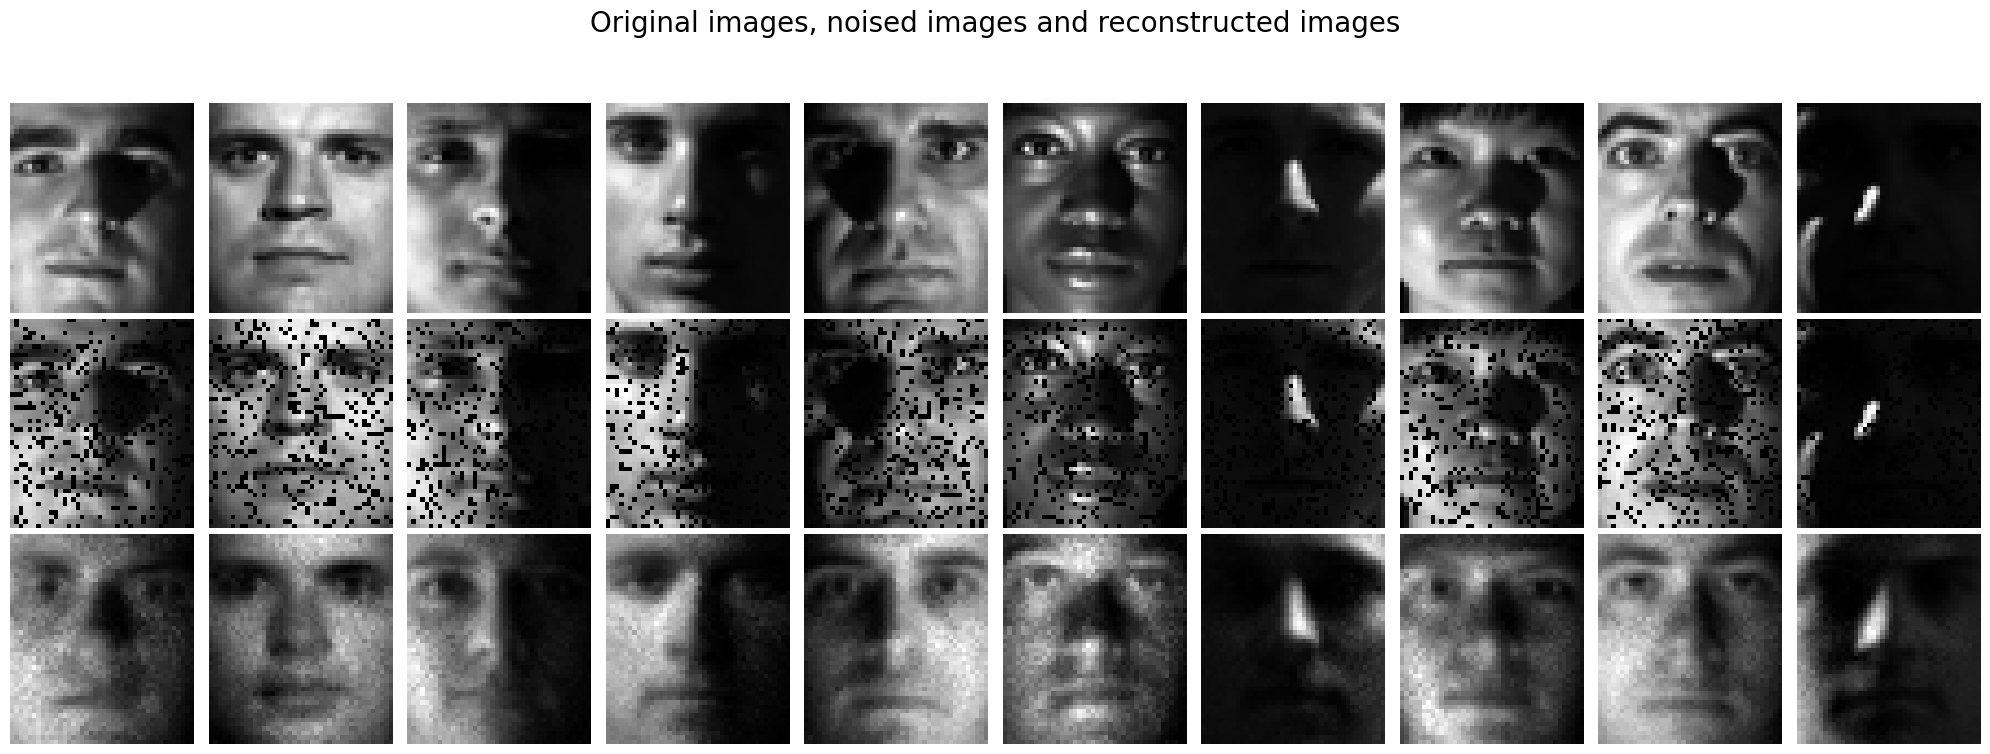

In [23]:
rmse_list = []
acc_list = []
nmi_list = []
p = 0.1

for i in range(5):
    print('==> Load YaleB dataset...')
    X, Y = load_data(root='data/CroppedYaleB', reduce=4)
    X = np.nan_to_num(X)
    V_hat, _, Y_hat, _ = train_test_split(X.T, Y, test_size = 0.1)
    V_hat = V_hat.T
    
    print('==> Add noise')
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    
    print('==> Apply L21 NMF...')
    model = L21N_NMF(n_components = len(set(Y_hat)), max_iter = 100, eps = 1e-3, print_output=True)
    W, H = model.fit(V_noise)  

    print('==> Evaluate RMSE...')
    rmse = RMSE(V_hat, W, H)  # Compute RMSE on original vs reconstructed
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))

    print('==> Evaluate Acc and NMI...')
    H = np.nan_to_num(H)
    Y_pred = assign_cluster_label(H.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)

    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    print("###############\n\n")

    reconstructed_img(V_hat, V_noise, W, H, p)

mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")

L1 Normalize Part

Basic Visual lize reconstructed image

==> Load ORL dataset ...
X_hat.shape=(1110, 400), Y_hat.shape=(400,)


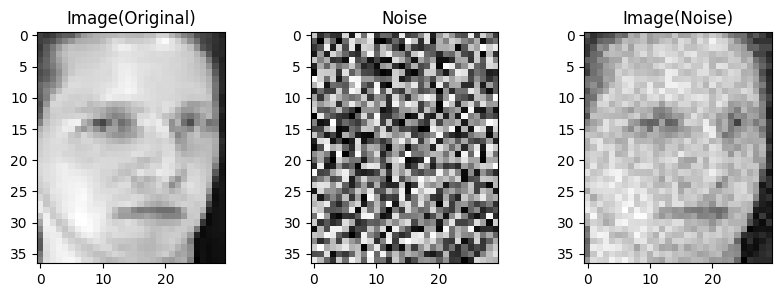

==> Apply NMF ...
D.shape=(100, 400), R.shape=(1110, 100)
==> Evaluate RMSE ...
RMSE = 10.996951046089487


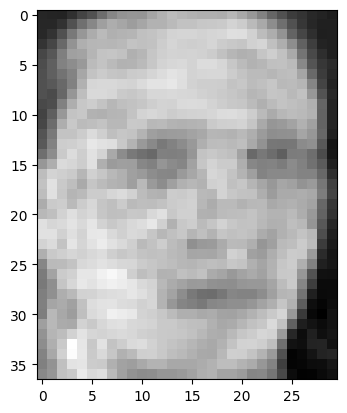

In [24]:
# Load dataset.
print('==> Load ORL dataset ...')
X_hat, Y_hat = load_data('data/ORL', reduce=3)
print('X_hat.shape={}, Y_hat.shape={}'.format(X_hat.shape, Y_hat.shape))

# Add Noise.
X_noise = np.random.rand(*X_hat.shape) * 40
X = X_hat + X_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(X_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(X_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(X[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
#model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.

n, m = X_hat.shape
k = 100
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
# U, V = L1_NMF(X_hat, U, V, 1000)
U, V = L1_NMF(X_hat, U, V, 1000)
# Obtain D and R separately.
#D = model.transform(X)
#R = model.components_()
#print('D.shape={}, R.shape={}'.format(D.shape, R.shape))

# Obtain D and R separately.


# Get D and R from your own NMF
D = V
R = U

# Print shapes
print('D.shape={}, R.shape={}'.format(D.shape, R.shape))

# Evaluate Root Means Square Errors .
print('==> Evaluate RMSE ...')
RMSE = sqrt(mean_squared_error(X_hat, R.dot(D)))
print('RMSE = {}'.format(RMSE))
plt.imshow(R.dot(D)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)

Create images with noise

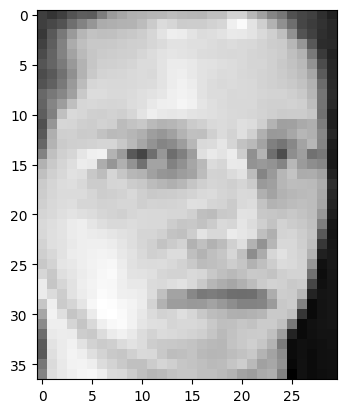

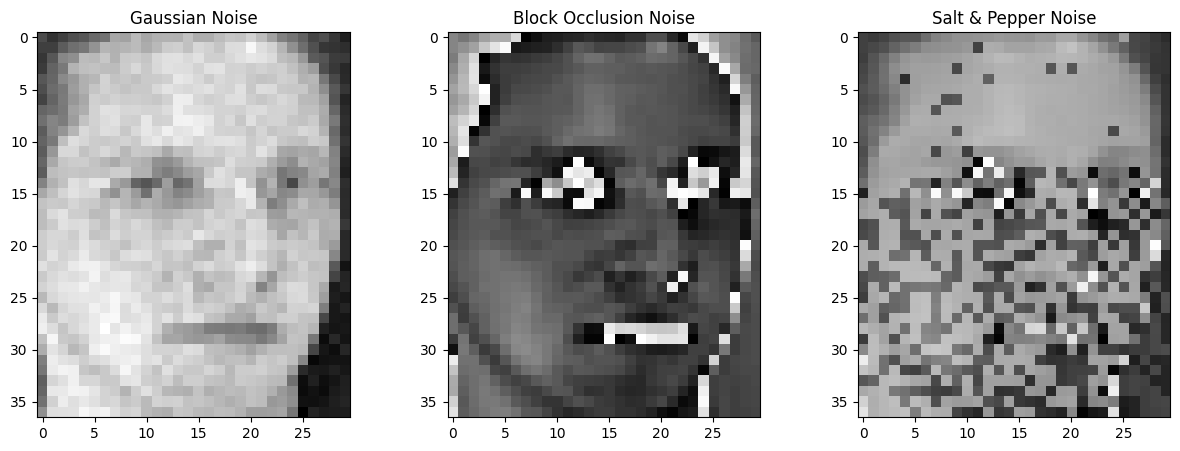

In [25]:
X_gaussian_noise = create_gaussian_noise(X_hat) + X_hat
X_BO_noise = create_block_occlusion_noise(X_hat) + X_hat
X_SP_noise = create_salt_pepper_noise(X_hat) + X_hat
plt.imshow(X_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
# Create a figure
fig = plt.figure(figsize=(15, 5))

# Add a subplot for the image with Gaussian noise
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(X_gaussian_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax1.title.set_text('Gaussian Noise')

# Add a subplot for the image with block occlusion noise
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(X_BO_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax2.title.set_text('Block Occlusion Noise')

# Add a subplot for the image with salt & pepper noise
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(X_SP_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax3.title.set_text('Salt & Pepper Noise')

# Display the figure with all subplots
plt.show()

==> Apply NMF ...
(1110, 400) (400, 400) (1110, 400)
==> Evaluate RMSE of gaussian noise image...
RMSE = 195.30251578659417
==> Apply NMF ...
==> Evaluate RMSE of block occusion noise image...
RMSE = 76.10168273187685
==> Apply NMF ...
==> Evaluate RMSE of salt & pepper noise image...
RMSE = 48.02936660807376


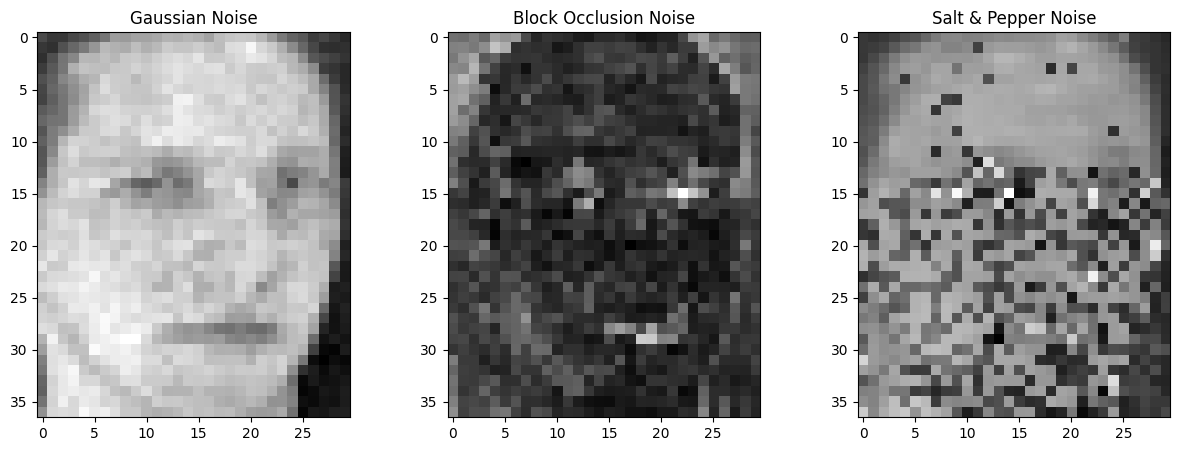

In [26]:
fig = plt.figure(figsize=(15, 5))
print('==> Apply NMF ...')
n, m = X_gaussian_noise.shape
k = 400
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
# U, V = L1_NMF(X_hat, U, V, 1000)
print(U.shape, V.shape, X_gaussian_noise.shape)
U, V = L1_NMF(X_gaussian_noise, U, V, 1000)
D = V
R = U
print('==> Evaluate RMSE of gaussian noise image...')
RMSE = sqrt(mean_squared_error(X_hat, R.dot(D)))
print('RMSE = {}'.format(RMSE))
progressed_1 = R.dot(D)
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(R.dot(D)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax1.title.set_text('Gaussian Noise')

print('==> Apply NMF ...')
n, m = X_BO_noise.shape
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
# U, V = L1_NMF(X_hat, U, V, 1000)
U, V = L1_NMF(X_BO_noise, U, V, 100)
D = V
R = U
print('==> Evaluate RMSE of block occusion noise image...')
RMSE = sqrt(mean_squared_error(X_hat, R.dot(D)))
print('RMSE = {}'.format(RMSE))
progressed_2 = R.dot(D)

# Add a subplot for the image with block occlusion noise
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(R.dot(D)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax2.title.set_text('Block Occlusion Noise')

print('==> Apply NMF ...')
n, m = X_SP_noise.shape
U = np.abs(np.random.rand(n, k))
V = np.abs(np.random.rand(k, m))
# U, V = L1_NMF(X_hat, U, V, 1000)
U, V = L1_NMF(X_SP_noise, U, V, 1000)
D = V
R = U
print('==> Evaluate RMSE of salt & pepper noise image...')
RMSE = sqrt(mean_squared_error(X_hat, R.dot(D)))
print('RMSE = {}'.format(RMSE))
progressed_3 = R.dot(D)
# Add a subplot for the image with salt & pepper noise
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(R.dot(D)[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
ax3.title.set_text('Salt & Pepper Noise')
# Display the figure with all subplots
plt.show()


Generate reconstructed images

In [27]:
def l1_norm(v):
    return np.linalg.norm(v, ord=1)

def L1_NMF(E, U, V, max_iters):
    for i in range(max_iters):
        V = V * ((U.T @ E) / (U.T @ U @ V + 1e-7))
        U = U * ((E @ V.T) / (U @ V @ V.T + 1e-7))
        
        # Normalize U
        norm = np.apply_along_axis(l1_norm, 0, U)
        U = U / norm
        V = V * norm[:, np.newaxis]

        i += 1
    return U, V

In [28]:
def add_salt_pepper_noise(X, salt_prob=0.01, pepper_prob=0.01):
    X_noised = X.copy()
    total_pixels = X.size
    
    # Add Salt noise
    num_salt = np.ceil(total_pixels * salt_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_salt) for i in X.shape]
    X_noised[tuple(coords)] = 1

    # Add Pepper noise
    num_pepper = np.ceil(total_pixels * pepper_prob).astype(int)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in X.shape]
    X_noised[tuple(coords)] = 0
    
    return X_noised
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse
def show_reconstructed_img(X, X_noise, W, H, p=0.1):
    # Mapping of X.shape[0] to appropriate image dimensions
    img_size = {
        1110: (37, 30),
        # Add other mappings as needed
    }

    # Determine image size dynamically based on X.shape[0]
    image_size = img_size.get(X.shape[0], (48, 42))  # Default to (48, 42) if not found
    
    X_re = np.dot(W, H)

    plt.figure(figsize=(20, 8))
    plt.suptitle(f"Original images and reconstructed images", size=20)

    # Showing original images
    for i in range(10):
        plt.subplot(3, 10, i+1)
        plt.imshow(X[:, i].reshape(image_size), cmap=plt.cm.gray)    
        plt.axis('off')  # Hide axis
    
    # Showing reconstructed images
    for i in range(10, 20):
        plt.subplot(3, 10, i+1)
        plt.imshow(X_re[:, i-10].reshape(image_size), cmap=plt.cm.gray)
        plt.axis('off')  # Hide axis
    
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(1110, 360), V.shape=(360, 360)
==> Evaluate RMSE...
RMSE = 17.3168
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.7250 (0.8461)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(1110, 360), V.shape=(360, 360)
==> Evaluate RMSE...
RMSE = 17.2609
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.6944 (0.8340)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(1110, 360), V.shape=(360, 360)
==> Evaluate RMSE...
RMSE = 17.3430
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.7417 (0.8522)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(1110, 360), V.shape=(360, 360)
==> Evaluate RMSE...
RMSE = 17.3442
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.7028 (0.8411)
###############


==> Load ORL dataset ...
(1110, 400)
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(1110, 360), V.shape=(360, 360)
==> Evaluate RMSE...
RMSE = 17.2795
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.7472 (0.8559)
###############




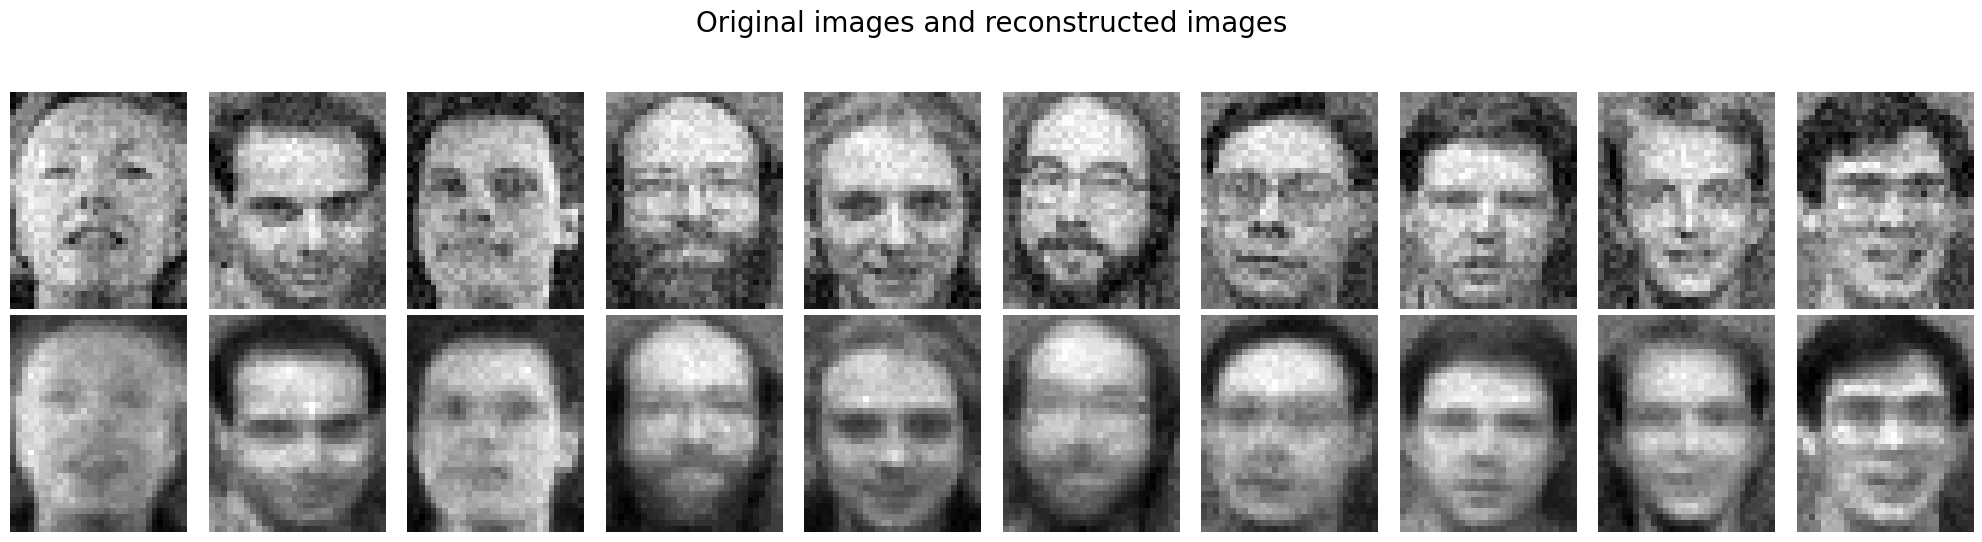

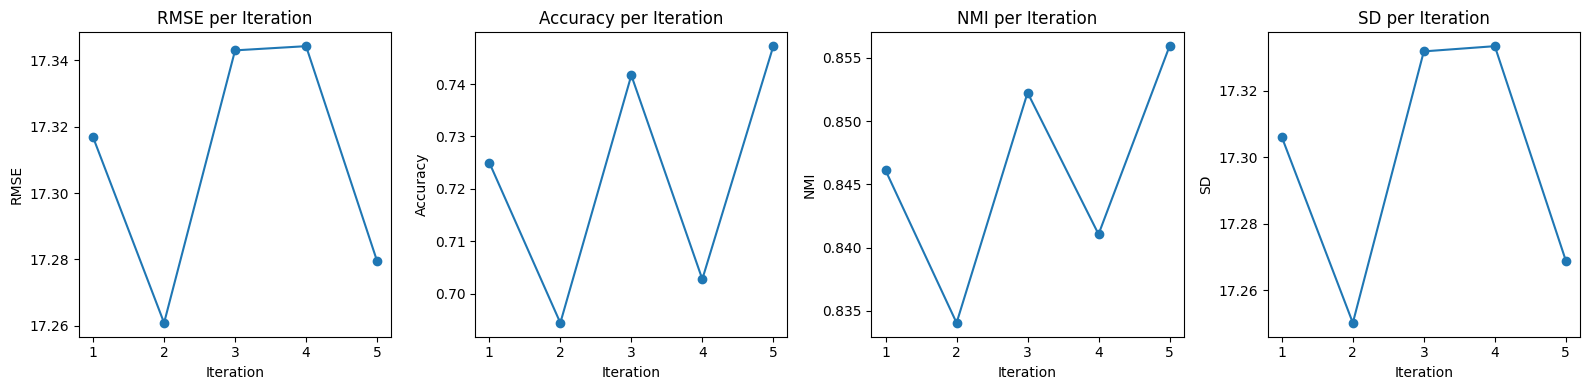

Mean RMSE: 17.3089
Mean Accuracy: 0.7222
Mean NMI: 0.8459


In [29]:
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse
# Set the number of iterations
num_iterations = 5
rmse_list = []
acc_list = []
nmi_list = []
sd_list = []
# Initialize lists to store RMSE and accuracy for each iteration
rmse_per_iteration = []
accuracy_per_iteration = []

for iteration in range(num_iterations):
    # Randomly split the data into train and test sets
    print('==> Load ORL dataset ...')
    X_hat, Y_hat = load_data('data/ORL', reduce=3)
    print(X_hat.shape)
    X_hat = np.nan_to_num(X_hat)
    V_hat, _, Y_hat, _ = train_test_split(X.T, Y_hat, test_size=0.1)
    V_hat = V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print('==> Add noise')
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    print('==> Apply L2 MUR NMF...')
    n, m = V_hat.shape
    k = 360
    U = np.abs(np.random.rand(n, k))
    V = np.abs(np.random.rand(k, m))
    U, V = L1_NMF(V_hat, U, V, 100)
    D = V
    R = U
    print('U.shape={}, V.shape={}'.format(U.shape, V.shape))
    print('==> Evaluate RMSE...')
    rmse = RMSE(V_hat, R, D)
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))
    print('==> Evaluate Acc and NMI...')
    V = np.nan_to_num(V)
    Y_pred = assign_cluster_label(V.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    accuracy_per_iteration.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    reconstruction_error = V_hat - R.dot(D)
    std_deviation = np.std(reconstruction_error)
    sd_list.append(std_deviation)
    print("###############\n\n")
show_reconstructed_img(V_hat, V_noise, R, D, 0.1)
# Plot RMSE, Accuracy, NMI, and SD for each iteration
plt.figure(figsize=(16, 4))

# RMSE subplot
plt.subplot(141)
plt.plot(range(1, num_iterations + 1), rmse_list, marker='o')
plt.title('RMSE per Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

# Accuracy subplot
plt.subplot(142)
plt.plot(range(1, num_iterations + 1), acc_list, marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# NMI subplot
plt.subplot(143)
plt.plot(range(1, num_iterations + 1), nmi_list, marker='o')
plt.title('NMI per Iteration')
plt.xlabel('Iteration')
plt.ylabel('NMI')

# SD subplot
plt.subplot(144)
plt.plot(range(1, num_iterations + 1), sd_list, marker='o')
plt.title('SD per Iteration')
plt.xlabel('Iteration')
plt.ylabel('SD')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")

==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(2016, 360), V.shape=(360, 2172)
==> Evaluate RMSE...
RMSE = 13.6127
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.2307 (0.3043)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(2016, 360), V.shape=(360, 2172)
==> Evaluate RMSE...
RMSE = 13.6295
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.2201 (0.2889)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(2016, 360), V.shape=(360, 2172)
==> Evaluate RMSE...
RMSE = 13.6547
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.2261 (0.2935)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(2016, 360), V.shape=(360, 2172)
==> Evaluate RMSE...
RMSE = 13.6353
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.2076 (0.2726)
###############


==> Load YaleB dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise
==> Apply L2 MUR NMF...
U.shape=(2016, 360), V.shape=(360, 2172)
==> Evaluate RMSE...
RMSE = 13.6062
==> Evaluate Acc and NMI...


C:\Users\78227\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Acc(NMI) = 0.2063 (0.2742)
###############




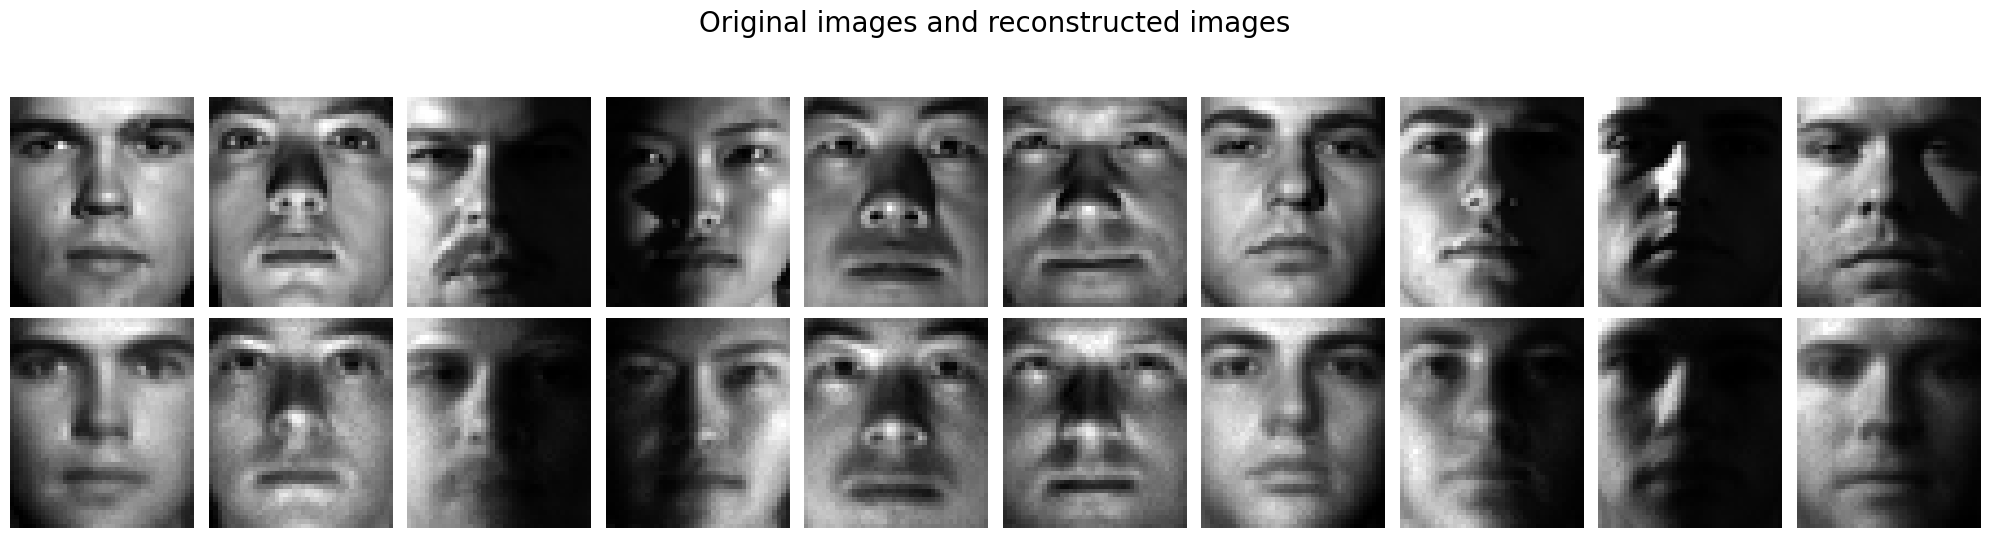

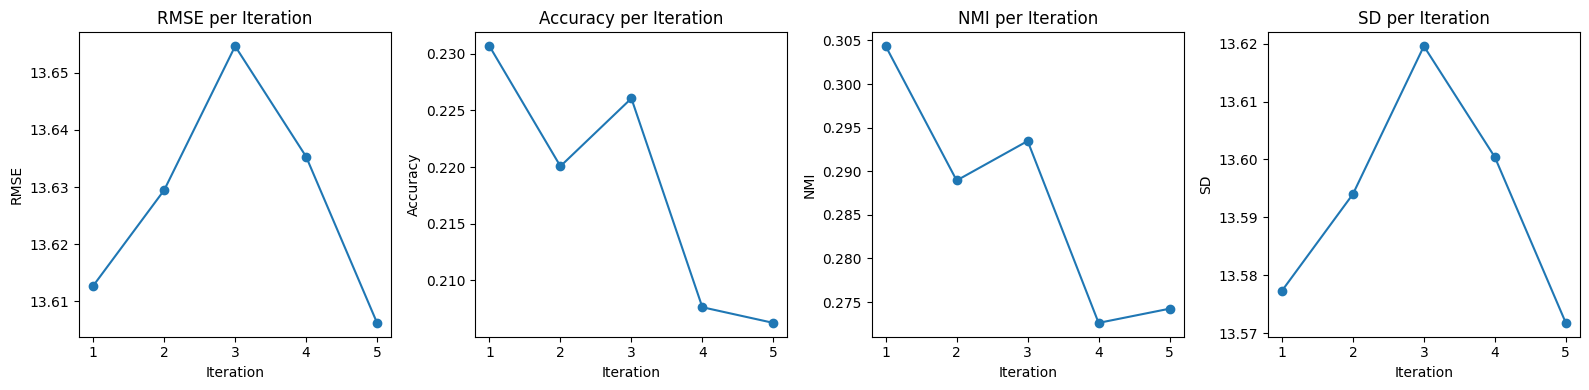

Mean RMSE: 13.6277
Mean Accuracy: 0.2181
Mean NMI: 0.2867


In [30]:
def RMSE(X_original, W, H):
    X_approx = np.dot(W, H)
    if np.isnan(X_approx).any() or np.isinf(X_approx).any():
        print("Warning: NaN or inf detected in X_approx")
    mse = np.mean((X_original - X_approx)**2)
    rmse = np.sqrt(mse)
    return rmse
# Set the number of iterations
num_iterations = 5
rmse_list = []
acc_list = []
nmi_list = []
sd_list = []
# Initialize lists to store RMSE and accuracy for each iteration
rmse_per_iteration = []
accuracy_per_iteration = []

for iteration in range(num_iterations):
    # Randomly split the data into train and test sets
    print('==> Load YaleB dataset ...')
    X_hat, Y_hat = load_data('data/CroppedYaleB', reduce=3)
    X_hat = np.nan_to_num(X_hat)
    V_hat, _, Y_hat, _ = train_test_split(X_hat.T, Y_hat, test_size=0.1)
    V_hat = V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))
    print('==> Add noise')
    V_noise = add_salt_pepper_noise(V_hat, salt_prob=0.1, pepper_prob=0.1)
    print('==> Apply L2 MUR NMF...')
    n, m = V_hat.shape
    k = 360
    U = np.abs(np.random.rand(n, k))
    V = np.abs(np.random.rand(k, m))
    U, V = L1_NMF(V_hat, U, V, 100)
    D = V
    R = U
    print('U.shape={}, V.shape={}'.format(U.shape, V.shape))
    print('==> Evaluate RMSE...')
    rmse = RMSE(V_hat, R, D)
    rmse_list.append(rmse)  
    print('RMSE = {:.4f}'.format(rmse))
    print('==> Evaluate Acc and NMI...')
    V = np.nan_to_num(V)
    Y_pred = assign_cluster_label(V.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    accuracy_per_iteration.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    reconstruction_error = V_hat - R.dot(D)
    std_deviation = np.std(reconstruction_error)
    sd_list.append(std_deviation)
    print("###############\n\n")
show_reconstructed_img(V_hat, V_noise, R, D, 0.1)
# Plot RMSE, Accuracy, NMI, and SD for each iteration
plt.figure(figsize=(16, 4))

# RMSE subplot
plt.subplot(141)
plt.plot(range(1, num_iterations + 1), rmse_list, marker='o')
plt.title('RMSE per Iteration')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

# Accuracy subplot
plt.subplot(142)
plt.plot(range(1, num_iterations + 1), acc_list, marker='o')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# NMI subplot
plt.subplot(143)
plt.plot(range(1, num_iterations + 1), nmi_list, marker='o')
plt.title('NMI per Iteration')
plt.xlabel('Iteration')
plt.ylabel('NMI')

# SD subplot
plt.subplot(144)
plt.plot(range(1, num_iterations + 1), sd_list, marker='o')
plt.title('SD per Iteration')
plt.xlabel('Iteration')
plt.ylabel('SD')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

mean_rmse = np.mean(rmse_list)
mean_acc = np.mean(acc_list)
mean_nmi = np.mean(nmi_list)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean NMI: {mean_nmi:.4f}")